In [1]:

import matplotlib.pyplot as plt

In [2]:
#from rnaflow.data.process_data import *
import numpy as np
import glob
from Bio.PDB.PDBParser import PDBParser
import pickle
#import torch
#from transformers import * ### SciBert model
from tqdm import tqdm
import pandas as pd
import os
import urllib.request

def download_and_filter_nakb(csv_file, pdb_out_dir, pdb_desc_csv='data/NAKB_descriptors.csv', save=False):

    print(f"Processing {csv_file}.")
    descriptor_csv= pd.read_csv(pdb_desc_csv)
    RNA_descriptor_list = []
    RNA_Prot_descriptor_list = []  
    DNA_descriptor_list = []
    DNA_Prot_descriptor_list = []


    # filter to protein-RNA complexes
    orig_df = pd.read_csv(csv_file)
    rna_df = orig_df[orig_df["polyclass"] == "Protein/RNA"][["pdbid"]].reset_index(drop=True)
    dna_df = orig_df[orig_df["polyclass"] == "Protein/DNA"][["pdbid"]].reset_index(drop=True)

    print(f"Number of Data Points: {len(rna_df)}.")
 ## Create output directory
    if not os.path.exists(pdb_out_dir):
        os.makedirs(pdb_out_dir)
    if not os.path.exists(f'{pdb_out_dir}/rna'):
        os.makedirs(f'{pdb_out_dir}/rna')
    if not os.path.exists(f'{pdb_out_dir}/dna'):
        os.makedirs(f'{pdb_out_dir}/dna')
  
    # RNA complexes
    rna_pdb_ids = list(set(rna_df["pdbid"].tolist()))
    for i in rna_pdb_ids:        
        for pdb_id in descriptor_csv["pdbid"]:
            if i == pdb_id:
                count = descriptor_csv.index[descriptor_csv["pdbid"] == pdb_id].tolist()[0]
                ## RNA descriptors
                RNA_descriptor_list.append((pdb_id,descriptor_csv["NAKBnaList"][count]))
                RNA_Prot_descriptor_list.append((pdb_id,descriptor_csv["NAKBprotList"][count]))

    print(f"Protein-RNA complexes: {len(rna_pdb_ids)}.")
    i = 0
    for pdb_id in tqdm(rna_pdb_ids):
        # print(f'http://files.rcsb.org/download/{pdb_id}.pdb')
        # break
        ## if pdb file already exists, skip
        if os.path.exists(f'{pdb_out_dir}/rna/{pdb_id}.pdb'):
            i+=1
            print(f"Skipping {pdb_id}.")
            continue
        try:
            urllib.request.urlretrieve(f'http://files.rcsb.org/download/{pdb_id}.pdb', 
            f'{pdb_out_dir}/rna/{pdb_id}.pdb')
            i+=1
        except:
            continue
            #print(f"PDB not found for {pdb_id}.")

    print(f"Saved {i} complexes in {pdb_out_dir}.")

    # DNA complexes
    dna_pdb_ids = list(set(dna_df["pdbid"].tolist()))
    for i in dna_pdb_ids:        
        for pdb_id in descriptor_csv["pdbid"]:
            if i == pdb_id:
                count = descriptor_csv.index[descriptor_csv["pdbid"] == pdb_id].tolist()[0]
                DNA_descriptor_list.append((pdb_id,descriptor_csv["NAKBnaList"][count]))
                DNA_Prot_descriptor_list.append((pdb_id,descriptor_csv["NAKBprotList"][count]))
     
    print(f"Protein-DNA complexes: {len(dna_pdb_ids)}.")
    i = 0
    for pdb_id in tqdm(dna_pdb_ids):
        ## if pdb file already exists, skip
        if os.path.exists(f'{pdb_out_dir}/dna/{pdb_id}.pdb'):
            i+=1
            print(f"Skipping {pdb_id}.")
            continue
        try:
            urllib.request.urlretrieve(f'http://files.rcsb.org/download/{pdb_id}.pdb', 
            f'{pdb_out_dir}/dna/{pdb_id}.pdb')
            i+=1
        except:
            continue
            #print(f"PDB not found for {pdb_id}.")
    print(f"Saved {i} complexes in {pdb_out_dir}.")

    rna_desc_list = [(x[0], np.nan_to_num(x[1])) for x in RNA_descriptor_list]
    rna_prot_desc_list = [(x[0], np.nan_to_num(x[1])) for x in RNA_Prot_descriptor_list]
    dna_desc_list = [(x[0], np.nan_to_num(x[1])) for x in DNA_descriptor_list]
    dna_prot_desc_list = [(x[0], np.nan_to_num(x[1])) for x in DNA_Prot_descriptor_list]

    if save:
        rna_desc_df = pd.DataFrame(rna_desc_list, columns=["pdbid", "descriptor"])
        rna_prot_desc_df = pd.DataFrame(rna_prot_desc_list, columns=["pdbid", "descriptor"])
        dna_desc_df = pd.DataFrame(dna_desc_list, columns=["pdbid", "descriptor"])
        dna_prot_desc_df = pd.DataFrame(dna_prot_desc_list, columns=["pdbid", "descriptor"])
        ## Nake the rna_prot a part of rna_desc
        rna_desc_df["prot_descriptor"] = rna_prot_desc_df["descriptor"]
        rna_desc_df.to_csv(f'{pdb_out_dir}/rna_protein_descriptors.csv', index=False)
        dna_desc_df["prot_descriptor"] = dna_prot_desc_df["descriptor"]
        dna_desc_df.to_csv(f'{pdb_out_dir}/dna_protein_descriptors.csv', index=False)

        return rna_desc_list, rna_prot_desc_list, dna_desc_list, dna_prot_desc_list

    return rna_desc_list, rna_prot_desc_list, dna_desc_list, dna_prot_desc_list

############ ONE CLASS TO READ THEM ALL ################



def calculate_distance_matrix(arr1, arr2):
    """
    Calculate the pairwise Euclidean distance matrix between two arrays.
    """
    return np.linalg.norm(arr1[:, np.newaxis] - arr2, axis=2)
## Distance matrix to contact map
def distance_matrix_to_contact_map(distance_matrix, threshold=7):
    ## Set values below threshold to 1 and above to 0
    contact_map = np.zeros_like(distance_matrix)
    contact_map[distance_matrix < threshold] = 1
    return contact_map


#### Download data and read PDBs and save as pickle

#### ONE CLASS TO READ THEM ALL


In [ ]:
class PDBComplex:
    protein_letters_3to1 = {
        'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
        'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
        'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
        'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'
    }

    def __init__(self, pdb_file):
        parser = PDBParser(QUIET=True)
        self.structure = parser.get_structure('', pdb_file)
    
    def get_rna_seq_and_coords(self):
        seq = ""
        coords = []
        model = self.structure[0]
        chain_ids = []
        for chain in model:
            for residue in chain:
                if residue.resname in ["A", "G", "C", "U"]:
                    if "P" not in residue: continue
                    P_coord = residue["P"].coord

                    if "C3'" not in residue: continue
                    C_coord = residue["C3'"].coord

                    if residue.resname in ["C", "U"]:
                        if "N1" not in residue: continue
                        N_coord = residue["N1"].coord
                    else:
                        if "N9" not in residue: continue
                        N_coord = residue["N9"].coord

                    seq += residue.resname
                    coords.append([P_coord, C_coord, N_coord])
                    chain_ids.append(chain.id)
        
        assert len(seq) == len(coords)
        return seq, np.array(coords), chain_ids

    def get_protein_seq_and_coords(self):
        seq = ""
        coords = []
        model = self.structure[0]
        chain_ids = []
        for chain in model:
            for residue in chain:
                if residue.resname in self.protein_letters_3to1.keys():
                    if "CA" not in residue: continue
                    CA_coord = residue["CA"].coord

                    if "N" not in residue: continue
                    N_coord = residue["N"].coord

                    if "C" not in residue: continue
                    C_coord = residue["C"].coord

                    seq += self.protein_letters_3to1[residue.resname]
                    coords.append([N_coord, CA_coord, C_coord])
                    chain_ids.append(chain.id)
        
        assert len(seq) == len(coords)
        return seq, np.array(coords), chain_ids

    def get_dna_seq_and_coords(self):
        seq = ""
        coords = []
        model = self.structure[0]
        chain_ids = []
        for chain in model:
            for residue in chain:
                if residue.resname in ["DA", "DG", "DC", "DT"]:
                    if "P" not in residue: continue
                    P_coord = residue["P"].coord

                    if "C3'" not in residue: continue
                    C_coord = residue["C3'"].coord

                    if residue.resname in ["DC", "DT"]:
                        if "N1" not in residue: continue
                        N_coord = residue["N1"].coord
                    else:
                        if "N9" not in residue: continue
                        N_coord = residue["N9"].coord

                    seq += residue.resname[1]
                    coords.append([P_coord, C_coord, N_coord])
                    chain_ids.append(chain.id)
        
        assert len(seq) == len(coords)
        return seq, np.array(coords), chain_ids

    @staticmethod
    def process_rna_protein_complexes(pdb_out_dir, save=False):
        rna_paths = glob.glob(f'{pdb_out_dir}/rna/*.pdb')
        rna_desc_df = pd.read_csv(f'{pdb_out_dir}/rna_protein_descriptors.csv')
        rna_protein_dump = []

        for filepath in tqdm(rna_paths):
            p = PDBParser(PERMISSIVE=1, QUIET=True)
            structure = p.get_structure(filepath[-8:-4], filepath)
            header = structure.header
            resolution = header.get('resolution')
            resolution = resolution if resolution is not None else "0"
            deposit_date = header.get('deposition_date')
            pdb_id = filepath[-8:-4]

            rna_descriptor = "0"
            protein_descriptor = "0"
            if len(rna_desc_df[rna_desc_df["pdbid"] == pdb_id]) > 0:
                rna_descriptor = rna_desc_df[rna_desc_df["pdbid"] == pdb_id]["descriptor"].values[0]
                protein_descriptor = rna_desc_df[rna_desc_df["pdbid"] == pdb_id]["prot_descriptor"].values[0]

            pdb_complex = PDBComplex(filepath)
            rna_seq, rna_full_coords, rna_chain_ids = pdb_complex.get_rna_seq_and_coords()
            protein_seq, protein_full_coords, protein_chain_ids = pdb_complex.get_protein_seq_and_coords()

            if rna_seq and protein_seq:
                rna_protein_dict = {
                    "pdb_id": pdb_id,
                    "rna_seq": rna_seq,
                    "rna_coords": rna_full_coords,
                    "protein_seq": protein_seq,
                    "protein_coords": protein_full_coords,
                    "rna_chain_ids": rna_chain_ids,
                    "protein_chain_ids": protein_chain_ids,
                    "deposit_date": deposit_date,
                    "rna_descriptor": rna_descriptor,
                    "protein_descriptor": protein_descriptor,
                    "resolution": resolution
                }
                rna_protein_dump.append(rna_protein_dict)

        rna_protein_dump_clean = [i for i in rna_protein_dump if i["rna_seq"] and i["protein_seq"]]
        print(f"Number of Protein-RNA complexes: {len(rna_protein_dump_clean)}.")
        if save:
            with open(f'{pdb_out_dir}/new_data/rna_protein_complexes.pkl', 'wb') as f:
                pickle.dump(rna_protein_dump_clean, f)
        return rna_protein_dump_clean

    @staticmethod
    def process_dna_protein_complexes(pdb_out_dir, save=False):
        dna_paths = glob.glob(f'{pdb_out_dir}/dna/*.pdb')
        dna_desc_df = pd.read_csv(f'{pdb_out_dir}/dna_protein_descriptors.csv')
        dna_protein_dump = []

        for filepath in tqdm(dna_paths):
            p = PDBParser(PERMISSIVE=1, QUIET=True)
            structure = p.get_structure(filepath[-8:-4], filepath)
            header = structure.header
            resolution = header.get('resolution')
            resolution = resolution if resolution is not None else "0"
            deposit_date = header.get('deposition_date')
            pdb_id = filepath[-8:-4]

            dna_descriptor = "0"
            protein_descriptor = "0"
            if len(dna_desc_df[dna_desc_df["pdbid"] == pdb_id]) > 0:
                dna_descriptor = dna_desc_df[dna_desc_df["pdbid"] == pdb_id]["descriptor"].values[0]
                protein_descriptor = dna_desc_df[dna_desc_df["pdbid"] == pdb_id]["prot_descriptor"].values[0]

            pdb_complex = PDBComplex(filepath)
            dna_seq, dna_full_coords, dna_chain_ids = pdb_complex.get_dna_seq_and_coords()
            protein_seq, protein_full_coords, protein_chain_ids = pdb_complex.get_protein_seq_and_coords()

            if dna_seq and protein_seq:
                dna_protein_dict = {
                    "pdb_id": pdb_id,
                    "dna_seq": dna_seq,
                    "dna_coords": dna_full_coords,
                    "protein_seq": protein_seq,
                    "protein_coords": protein_full_coords,
                    "dna_chain_ids": dna_chain_ids,
                    "protein_chain_ids": protein_chain_ids,
                    "deposit_date": deposit_date,
                    "dna_descriptor": dna_descriptor,
                    "protein_descriptor": protein_descriptor,
                    "resolution": resolution
                }
                dna_protein_dump.append(dna_protein_dict)

        dna_protein_dump_clean = [i for i in dna_protein_dump if i["dna_seq"] and i["protein_seq"]]
        print(f"Number of Protein-DNA complexes: {len(dna_protein_dump_clean)}.")
        if save:
            with open(f'{pdb_out_dir}/new_data/dna_protein_complexes.pkl', 'wb') as f:
                pickle.dump(dna_protein_dump_clean, f)
        return dna_protein_dump_clean


In [ ]:
# pdb_out_dir = 'path'

# cleaned_rna_data = PDBComplex.process_rna_protein_complexes(pdb_out_dir, save=True)
# cleaned_dna_data = PDBComplex.process_dna_protein_complexes(pdb_out_dir, save=True)

In [2]:
## Load RNA data
#dict_keys(['pdb_id', 'rna_seq', 'rna_coords', 'protein_seq', 'protein_coords', 'rna_chain_ids', 'protein_chain_ids', 'deposit_date', 'rna_descriptor', 'protein_descriptor', 'resolution'])
rna_data = pickle.load(open('path', 'rb'))
## Load DNA data
dna_data = pickle.load(open('path', 'rb'))

#### NaN Sanity Checks

In [3]:
## Sanity check of rna data
print(len(rna_data))
## Check NaN for values of keys rna_coords, protein_coords, resolution in the dictionary for all dictionaries in the rna_data list
for i in range(len(rna_data)):
    if np.isnan(rna_data[i]['rna_coords']).any() or np.isnan(rna_data[i]['protein_coords']).any():
        print(i)

## Check blank strings for values of keys rna_seq, protein_seq, rna_chain_ids, protein_chain_ids, deposit_date, rna_descriptor, protein_descriptor in the dictionary for all dictionaries in the rna_data list
for i in range(len(rna_data)):
    if rna_data[i]['rna_seq'] == '' or rna_data[i]['protein_seq'] == '' or rna_data[i]['rna_chain_ids'] == '' or rna_data[i]['protein_chain_ids'] == '' or rna_data[i]['deposit_date'] == '' or rna_data[i]['rna_descriptor'] == '' or rna_data[i]['protein_descriptor'] == '': 
        print(i)

### sanity check of dna data
print(len(dna_data))
## Check NaN for values of keys dna_coords, protein_coords, resolution in the dictionary for all dictionaries in the dna_data list
for i in range(len(dna_data)):
   if np.isnan(dna_data[i]['dna_coords']).any() or np.isnan(dna_data[i]['protein_coords']).any():
       print(i)
## Check blank strings for values of keys dna_seq, protein_seq, dna_chain_ids, protein_chain_ids, deposit_date, dna_descriptor, protein_descriptor in the dictionary for all dictionaries in the dna_data list
for i in range(len(dna_data)):
  if dna_data[i]['dna_seq'] == '' or dna_data[i]['protein_seq'] == '' or dna_data[i]['dna_chain_ids'] == '' or dna_data[i]['protein_chain_ids'] == '' or dna_data[i]['deposit_date'] == '' or dna_data[i]['dna_descriptor'] == '' or dna_data[i]['protein_descriptor'] == '':
    print(i)

        

3138
7099


#### Calculate chain lengths and store them as a list in the root dictionary

In [4]:
def calc_chain_lengths(data, mode='rna'):
    chain_lengths = []
    for i in range(len(data)):
        if mode == 'rna':
            chain_lengths.append(len(data[i]['rna_chain_ids']))
        elif mode == 'dna':
            chain_lengths.append(len(data[i]['dna_chain_ids']))
        elif mode == 'protein':
            chain_lengths.append(len(data[i]['protein_chain_ids']))    
    return chain_lengths


for i in range(len(rna_data)):
    rna_tester = rna_data[i]
    chain_lengths = {}
    for chain in rna_tester["rna_chain_ids"]:
        if chain in chain_lengths:
            chain_lengths[chain] += 1
        else:
            chain_lengths[chain] = 1
    rna_chain_lengths = list(chain_lengths.values())
    rna_tester['rna_chain_lengths'] = rna_chain_lengths

for i in range(len(rna_data)):
    rna_tester = rna_data[i]
    chain_lengths = {}
    for chain in rna_tester["protein_chain_ids"]:
        if chain in chain_lengths:
            chain_lengths[chain] += 1
        else:
            chain_lengths[chain] = 1
    protein_chain_lengths = list(chain_lengths.values())
    rna_tester['protein_chain_lengths'] = protein_chain_lengths    

for i in range(len(dna_data)):
    dna_tester = dna_data[i]
    chain_lengths = {}
    for chain in dna_tester["dna_chain_ids"]:
        if chain in chain_lengths:
            chain_lengths[chain] += 1
        else:
            chain_lengths[chain] = 1
    dna_chain_lengths = list(chain_lengths.values())
    dna_tester['dna_chain_lengths'] = dna_chain_lengths

for i in range(len(dna_data)):
    dna_tester = dna_data[i]
    chain_lengths = {}
    for chain in dna_tester["protein_chain_ids"]:
        if chain in chain_lengths:
            chain_lengths[chain] += 1
        else:
            chain_lengths[chain] = 1
    protein_chain_lengths = list(chain_lengths.values())
    dna_tester['protein_chain_lengths'] = protein_chain_lengths


#### Filtering (Based on chain length thresholds and resolution threshold)

In [15]:
## Filter data based on chain lengths of rna and dna being more than 5 and less than 100
rna_data_filtered = [rna_data[i] for i in range(len(rna_data)) if all([x > 4 and x < 100 for x in rna_data[i]['rna_chain_lengths']])]
### Filter data based on chain lengths of RNA-complexed protein being more than 5 and less than 800
rna_data_filtered = [rna_data_filtered[i] for i in range(len(rna_data_filtered)) if all([x > 4 and x < 800 for x in rna_data_filtered[i]['protein_chain_lengths']])]

### Filter data based on chain lengths of dna being more than 5 and less than 100
dna_data_filtered = [dna_data[i] for i in range(len(dna_data)) if all([x > 4 and x < 100 for x in dna_data[i]['dna_chain_lengths']])]
### Filter data based on chain lengths of DNA-complexed protein being more than 5 and less than 800
dna_data_filtered = [dna_data_filtered[i] for i in range(len(dna_data_filtered)) if all([x > 4 and x < 800 for x in dna_data_filtered[i]['protein_chain_lengths']])]
# print(len(rna_data_filtered))
# print(len(dna_data_filtered))


## Filter data based on resolution being less than 4.5 and more than 0
rna_data= [rna_data_filtered[i] for i in range(len(rna_data_filtered)) if float(rna_data_filtered[i]['resolution']) < 4.5 and float(rna_data_filtered[i]['resolution']) > 0]
dna_data= [dna_data_filtered[i] for i in range(len(dna_data_filtered)) if float(dna_data_filtered[i]['resolution']) < 4.5 and float(dna_data_filtered[i]['resolution']) > 0]

print(len(rna_data))
print(len(dna_data))


1383
5160


#### Add Contact Maps too

In [20]:
### Create contact maps for rna and dna data
def calculate_distance_matrix(arr1, arr2):
    """
    Calculate the pairwise Euclidean distance matrix between two arrays.
    """
    return np.linalg.norm(arr1[:, np.newaxis] - arr2, axis=2)
## Distance matrix to contact map
def distance_matrix_to_contact_map(distance_matrix, threshold=6):
    ## Set values below threshold to 1 and above to 0
    contact_map = np.zeros_like(distance_matrix)
    contact_map[distance_matrix < threshold] = 1
    return contact_map

for i in range(len(rna_data)):
    rna_tester = rna_data[i]
    rna_coords = rna_tester['rna_coords'][:,1,:]
    prot_coords = rna_tester['protein_coords'][:,1,:]
    complex_distance_map = calculate_distance_matrix(rna_coords, prot_coords)
    complex_contact_map = distance_matrix_to_contact_map(complex_distance_map)
    rna_tester['complex_contact_map'] = complex_contact_map
    rna_tester['complex_distance_map'] = complex_distance_map

for i in range(len(dna_data)):
    dna_tester = dna_data[i]
    dna_coords = dna_tester['dna_coords'][:,1,:]
    prot_coords = dna_tester['protein_coords'][:,1,:]
    complex_distance_map = calculate_distance_matrix(dna_coords, prot_coords)
    complex_contact_map = distance_matrix_to_contact_map(complex_distance_map)
    dna_tester['complex_contact_map'] = complex_contact_map
    dna_tester['complex_distance_map'] = complex_distance_map

### Filter data based on sum of contact map (complex_contact_map) being more than 0



1287
5064


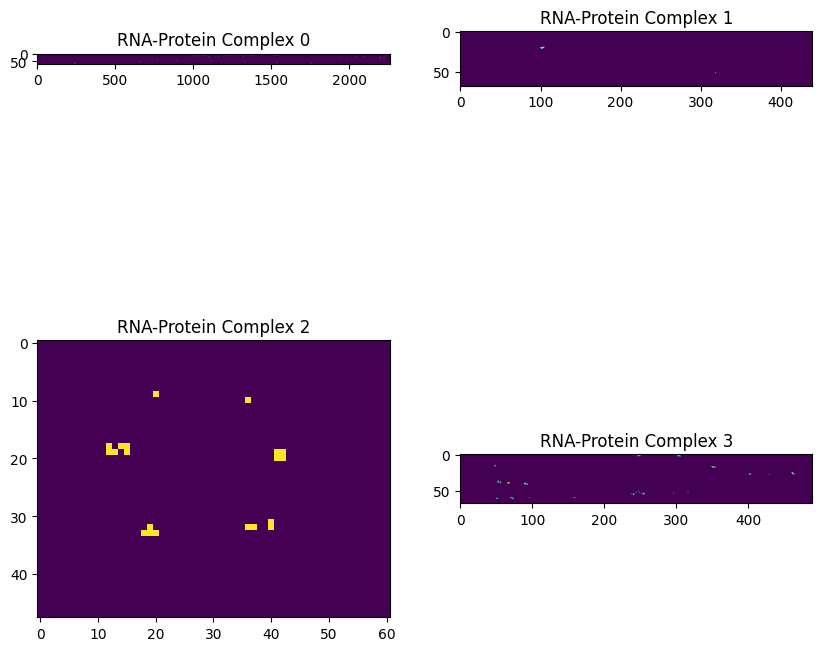

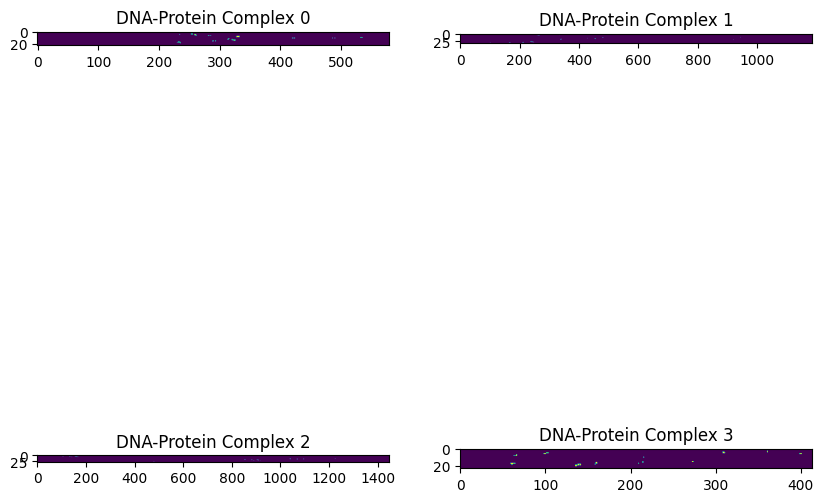

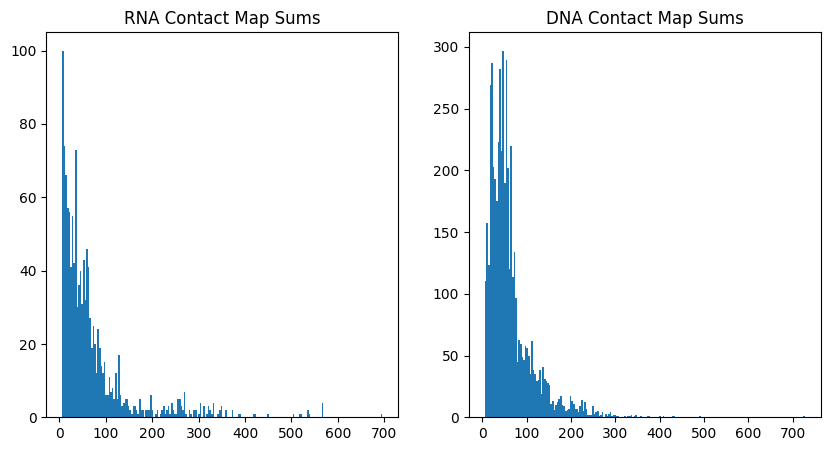

In [24]:
rna_data = [rna_data[i] for i in range(len(rna_data)) if np.sum(rna_data[i]['complex_contact_map']) > 5]
dna_data = [dna_data[i] for i in range(len(dna_data)) if np.sum(dna_data[i]['complex_contact_map']) > 5]
print(len(rna_data))
print(len(dna_data))



## Plot some contact maps
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i in range(4):
    axes[i].imshow(rna_data[i]['complex_contact_map'], cmap='viridis')
    axes[i].set_title(f'RNA-Protein Complex {i}')
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i in range(4):
    axes[i].imshow(dna_data[i]['complex_contact_map'], cmap='viridis')
    axes[i].set_title(f'DNA-Protein Complex {i}')
plt.show()


### Plot distribution of sum of contact maps
rna_contact_map_sums = [np.sum(rna_data[i]['complex_contact_map']) for i in range(len(rna_data))]
dna_contact_map_sums = [np.sum(dna_data[i]['complex_contact_map']) for i in range(len(dna_data))]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(rna_contact_map_sums, bins=200)
axes[0].set_title('RNA Contact Map Sums')
axes[1].hist(dna_contact_map_sums, bins=200)
axes[1].set_title('DNA Contact Map Sums')
plt.show()

           

In [25]:
### Save the filtered data
pickle.dump(rna_data, open('path', 'wb'))
pickle.dump(dna_data, open('path', 'wb'))



#### Data Exploration Plots

RNA Sequence length distribution


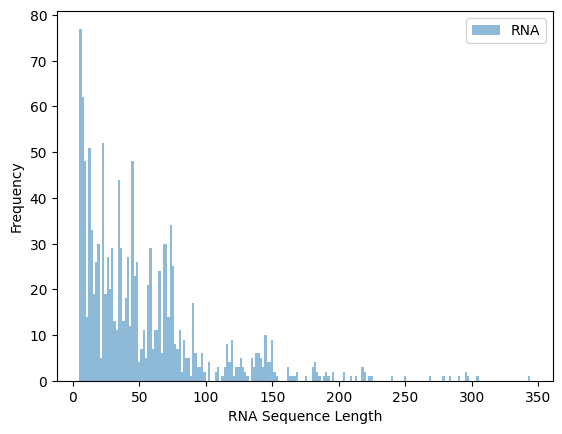

DNA Sequence length distribution


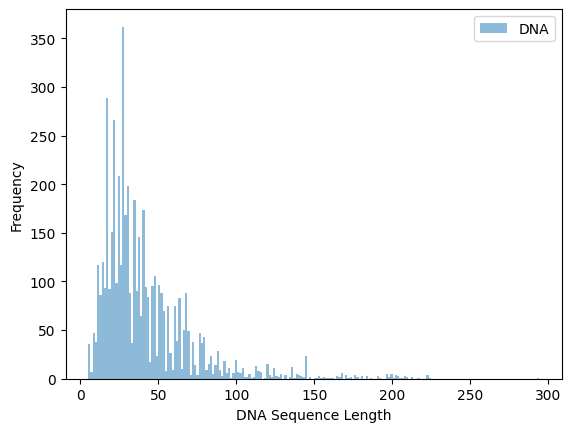

RNA-Complexed Protein length distribution


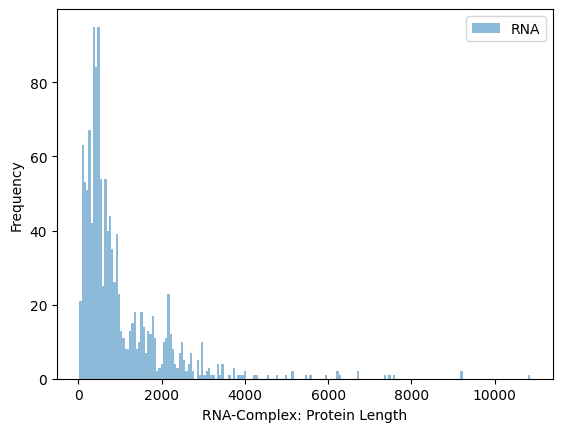

DNA-Complexed Protein length distribution


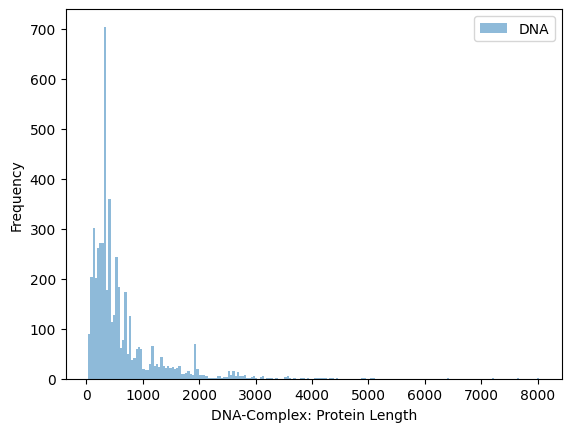

RNA Number of Chains distribution


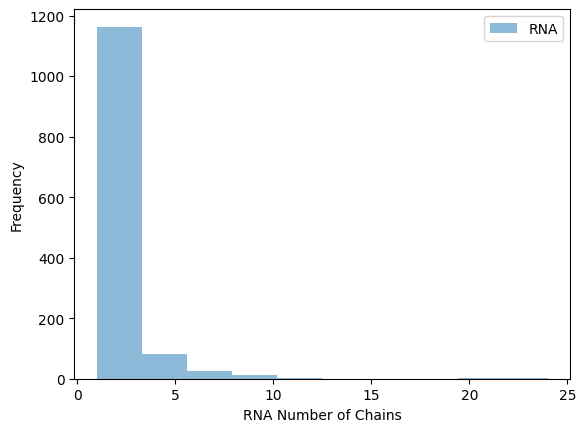

DNA Number of Chains distribution


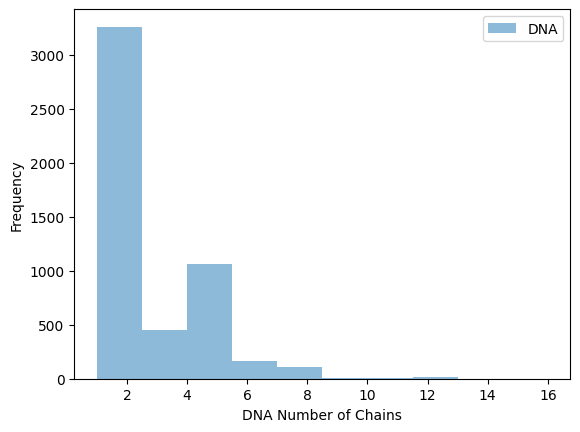

RNA Resolution distribution, Max: 4, Min: 1


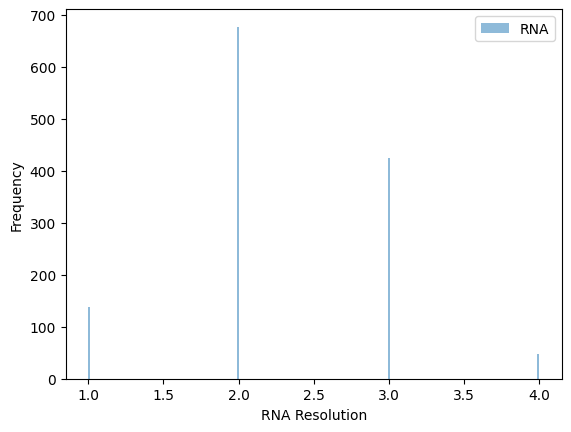

DNA Resolution distribution, Max: 4, Min: 0


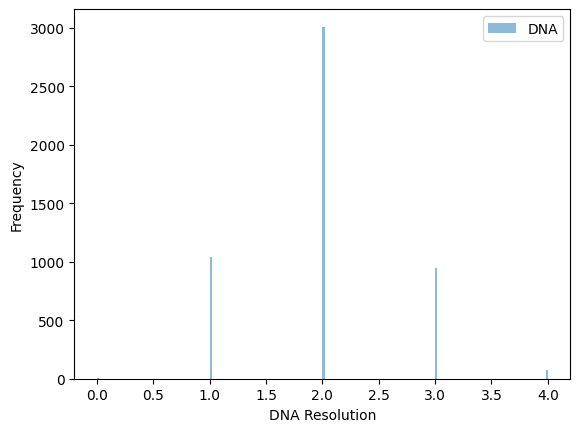

In [26]:
## Plot distribution of sequence lengths for RNA and DNA data
rna_seq_lengths = [len(rna_data[i]['rna_seq']) for i in range(len(rna_data))]
dna_seq_lengths = [len(dna_data[i]['dna_seq']) for i in range(len(dna_data))]
print("RNA Sequence length distribution")
plt.hist(rna_seq_lengths, bins=200, alpha=0.5, label='RNA')
plt.xlabel('RNA Sequence Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

print("DNA Sequence length distribution")
plt.hist(dna_seq_lengths, bins=200, alpha=0.5, label='DNA')
plt.xlabel('DNA Sequence Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


## Plot distribution of Protein length for RNA and DNA data

rna_protein_lengths = [len(rna_data[i]['protein_seq']) for i in range(len(rna_data))]
dna_protein_lengths = [len(dna_data[i]['protein_seq']) for i in range(len(dna_data))]

print("RNA-Complexed Protein length distribution")
plt.hist(rna_protein_lengths, bins=200, alpha=0.5, label='RNA')
plt.xlabel('RNA-Complex: Protein Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

print("DNA-Complexed Protein length distribution")
plt.hist(dna_protein_lengths, bins=200, alpha=0.5, label='DNA')
plt.xlabel('DNA-Complex: Protein Length')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


## Plot distribution of number of chains for RNA and DNA data
## Chains are alphabets, give me number of unique alphabets in the chain_ids


rna_num_chains = [len(set(rna_data[i]['rna_chain_ids'])) for i in range(len(rna_data))]
dna_num_chains = [len(set(dna_data[i]['dna_chain_ids'])) for i in range(len(dna_data))]

print("RNA Number of Chains distribution")
plt.hist(rna_num_chains, bins=10, alpha=0.5, label='RNA')
plt.xlabel('RNA Number of Chains')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

print("DNA Number of Chains distribution")
plt.hist(dna_num_chains, bins=10, alpha=0.5, label='DNA')
plt.xlabel('DNA Number of Chains')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

## Plot distrivution of resolution for RNA and DNA data by rounding off the resolution to nearest integer


rna_resolutions = [int(rna_data[i]['resolution']) for i in range(len(rna_data))]
dna_resolutions = [int(dna_data[i]['resolution']) for i in range(len(dna_data))]

print(f"RNA Resolution distribution, Max: {max(rna_resolutions)}, Min: {min(rna_resolutions)}")
plt.hist(rna_resolutions, bins=200, alpha=0.5, label='RNA')
plt.xlabel('RNA Resolution')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

print(f"DNA Resolution distribution, Max: {max(dna_resolutions)}, Min: {min(dna_resolutions)}")
plt.hist(dna_resolutions, bins=200, alpha=0.5, label='DNA')
plt.xlabel('DNA Resolution')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


In [4]:
rna_coords = rna_data[0]['rna_coords'][:,1,:]
prot_coords = rna_data[0]['protein_coords'][:,1,:]


#### Contact Map visualization as point clouds

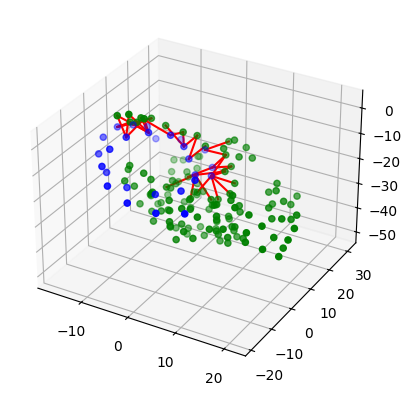

In [5]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rna_coords[:,0], rna_coords[:,1], rna_coords[:,2], c='b', marker='o')
ax.scatter(prot_coords[:,0], prot_coords[:,1], prot_coords[:,2], c='g', marker='o')
for i in range(rna_coords.shape[0]):
    for j in range(prot_coords.shape[0]):
        if np.linalg.norm(rna_coords[i] - prot_coords[j]) < 6: ### Threshold of 6
            ax.plot([rna_coords[i,0], prot_coords[j,0]], [rna_coords[i,1], prot_coords[j,1]], [rna_coords[i,2], prot_coords[j,2]], c='r')
plt.show()

